# 한국어 데이터로 챗봇 만들기

## Step 1. 데이터 수집하기

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!mkdir -p ~/aiffel/transformer_chatbot/data/
!ln -s ~/data/* ~/aiffel/transformer_chatbot/data/

ln: failed to create symbolic link '/aiffel/aiffel/transformer_chatbot/data/ChatbotData .csv': File exists


## Step 2. 데이터 전처리하기

In [3]:
data = pd.read_csv('/aiffel/aiffel/transformer_chatbot/data/ChatbotData .csv')
data

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [4]:
# 전처리 함수
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^a-zA-Zㄱ-ㅣ가-힣0-9?.!,]+", " ", sentence)
  #sentence = sentence.strip()
  return sentence

In [5]:
questions = data['Q'].apply(preprocess_sentence)
questions

0                         12시 땡 ! 
1                      1지망 학교 떨어졌어
2                     3박4일 놀러가고 싶다
3                  3박4일 정도 놀러가고 싶다
4                          ppl 심하네
                   ...            
11818             훔쳐보는 것도 눈치 보임 . 
11819             훔쳐보는 것도 눈치 보임 . 
11820                흑기사 해주는 짝남 . 
11821    힘든 연애 좋은 연애라는게 무슨 차이일까 ? 
11822                   힘들어서 결혼할까봐
Name: Q, Length: 11823, dtype: object

In [6]:
answers = data['A'].apply(preprocess_sentence)
answers

0                      하루가 또 가네요 . 
1                       위로해 드립니다 . 
2                     여행은 언제나 좋죠 . 
3                     여행은 언제나 좋죠 . 
4                      눈살이 찌푸려지죠 . 
                    ...            
11818          티가 나니까 눈치가 보이는 거죠 ! 
11819               훔쳐보는 거 티나나봐요 . 
11820                      설렜겠어요 . 
11821    잘 헤어질 수 있는 사이 여부인 거 같아요 . 
11822          도피성 결혼은 하지 않길 바라요 . 
Name: A, Length: 11823, dtype: object

In [7]:
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [8]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 . 


## Step 3. SubwordTextEncoder 사용하기

### 단어장(Vocabulary) 만들기

In [9]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [10]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8359]
END_TOKEN의 번호 : [8360]


In [11]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기 산정
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8361


### 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)

In [12]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5824, 604, 2496, 4171]
정수 인코딩 후의 21번째 답변 샘플: [2680, 7663, 8, 6374, 94, 1]


questions의 최소 길이 : 1
questions의 최대 길이 : 15
questions의 평균 길이 : 3.587414361837097
answers의 최소 길이 : 1
answers의 최대 길이 : 21
answers의 평균 길이 : 3.6936479742874058


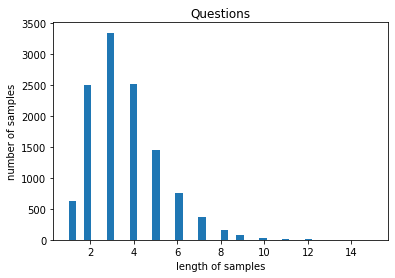

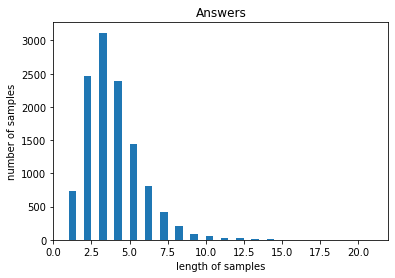

In [13]:
questions_len = [len(s.split()) for s in data['Q']]
answers_len = [len(s.split()) for s in data['A']]

print('questions의 최소 길이 : {}'.format(np.min(questions_len)))
print('questions의 최대 길이 : {}'.format(np.max(questions_len)))
print('questions의 평균 길이 : {}'.format(np.mean(questions_len)))
print('answers의 최소 길이 : {}'.format(np.min(answers_len)))
print('answers의 최대 길이 : {}'.format(np.max(answers_len)))
print('answers의 평균 길이 : {}'.format(np.mean(answers_len)))

plt.title('Questions')
plt.hist(questions_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Answers')
plt.hist(answers_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [14]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 15
print(MAX_LENGTH)

15


In [15]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 8 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [16]:
questions, answers = tokenize_and_filter(questions, answers)

print('초과 샘플 제거 후 questions 개수: {}'.format(len(questions)))
print('초과 샘플 제거 후 answers 개수: {}'.format(len(answers)))

초과 샘플 제거 후 questions 개수: 11573
초과 샘플 제거 후 answers 개수: 11573


### 교사 강요(Teacher Forcing) 사용하기

In [17]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용
# 이에 따라 outputs에서는 START_TOKEN을 제거
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## Step 4. 모델 구성하기

In [30]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [31]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

In [32]:
# 멀티 헤드 어텐션
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만들기
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용
    outputs = self.dense(concat_attention)

    return outputs

In [33]:
# 패딩 마스킹
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [34]:
# 룩 어헤드 마스킹
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [35]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [36]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [37]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [38]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [39]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

### 모델 생성

In [40]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3194624     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### 손실 함수(Loss function)

In [41]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

### 커스텀 된 학습률(Learning rate)

In [42]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

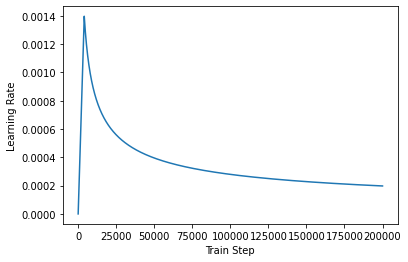

In [43]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### 모델 컴파일

In [44]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

### 훈련하기

In [45]:
EPOCHS = 30
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/30
181/181 [==============================] - 12s 34ms/step - loss: 3.9768 - accuracy: 0.0722
Epoch 2/30
181/181 [==============================] - 6s 33ms/step - loss: 3.2269 - accuracy: 0.1384
Epoch 3/30
181/181 [==============================] - 6s 34ms/step - loss: 2.7199 - accuracy: 0.1418
Epoch 4/30
181/181 [==============================] - 6s 34ms/step - loss: 2.5057 - accuracy: 0.1518
Epoch 5/30
181/181 [==============================] - 6s 32ms/step - loss: 2.3498 - accuracy: 0.1609
Epoch 6/30
181/181 [==============================] - 6s 33ms/step - loss: 2.1909 - accuracy: 0.1722
Epoch 7/30
181/181 [==============================] - 6s 33ms/step - loss: 2.0170 - accuracy: 0.1876
Epoch 8/30
181/181 [==============================] - 6s 33ms/step - loss: 1.8247 - accuracy: 0.2089
Epoch 9/30
181/181 [==============================] - 6s 33ms/step - loss: 1.6154 - accuracy: 0.2321
Epoch 10/30
181/181 [==============================] - 6s 33ms/step - loss: 1.3942 - accur

## Step 5. 모델 평가하기

In [46]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [47]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [49]:
sentence_generation("자연어처리 너무 어려워.")

입력 : 자연어처리 너무 어려워.
출력 : 하나씩 하나씩 하나씩 해보세요 . 


'하나씩 하나씩 하나씩 해보세요 . '

In [53]:
sentence_generation("여행가고 싶다")

입력 : 여행가고 싶다
출력 : 계획을 세워보세요 . 


'계획을 세워보세요 . '

In [54]:
sentence_generation("너무 피곤해")

입력 : 너무 피곤해
출력 : 푹 쉬세요 . 


'푹 쉬세요 . '

In [55]:
sentence_generation("오늘은 일찍 잘거야.")

입력 : 오늘은 일찍 잘거야.
출력 : 축하드려요


'축하드려요'

In [60]:
sentence_generation("배고프당")

입력 : 배고프당
출력 : 얼른 맛난 음식 드세요 . 


'얼른 맛난 음식 드세요 . '

------

## 회고
1. 한국어 전처리를 통해 학습 데이터셋을 구축하였는가?  
공백과 특수문자 처리, 토크나이징, 병렬데이터 전처리를 통해 한국어 전처리를 진행하여 학습 데이터셋을 구축하였다.  
2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였는가?  
구현한 트랜스포머 모델로 한국어 병렬 데이터 학습한 결과 안정적으로 수렴하는 편이었다.  
3. 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였는가?  
뭔가 부족하게 답변을 하지만 그래도 맥락에서 완전히 벗어나는 답을 하지는 않았다.